In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
import copy
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from utils.losses import EnergyScore, KernelScore, VariogramScore
from models.fno import FNO
from models.uno import UNO
from models.pfno import PFNO_Wrapper
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import KSDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloaders

In [2]:
batch_size = 32
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
temporal_downscaling = 2
init_steps = 20 # Initial steps
t_start = 0 # Where to start input
pred_horizon = 20 # Prediction horizon across time domain

In [3]:
data_dir = "../data/KS/processed/"
train_data = KSDataset(data_dir, test = False, downscaling_factor=1, mode = "autoregressive",
                        pred_horizon=pred_horizon, t_start=t_start, init_steps=init_steps,
                        temporal_downscaling_factor=temporal_downscaling)
test_data = KSDataset(data_dir, test = True, mode = "autoregressive", pred_horizon = pred_horizon,
                       init_steps=init_steps, t_start=t_start,
                       temporal_downscaling_factor=temporal_downscaling)

# Get domain and range
x,t = train_data.get_coordinates()
L = train_data.get_domain_range()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

n_train = len(train_loader)
n_test = len(test_loader)

## Visualize samples

Text(0, 0.5, 'Pred')

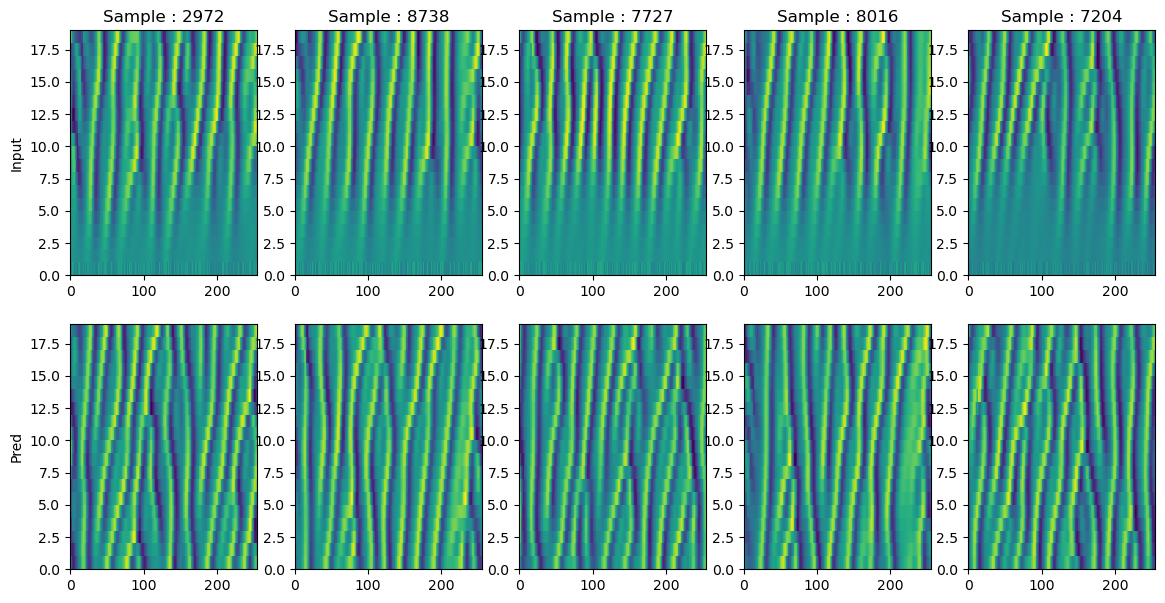

In [4]:
samples = np.random.randint(0, train_data.__len__(),5)

fig, axs = plt.subplots(2, 5, figsize=(14, 7))
for s, sample in enumerate(samples):
    a,u = train_data.__getitem__(sample)
    a = a[0]
    u = u[0]
    axs[0,s].pcolormesh(a, shading = "nearest")
    axs[1,s].pcolormesh(u, shading = "nearest")
    axs[0,s].set_title(f"Sample : {sample}")
axs[0, 0].set_ylabel(f"Input")
axs[1, 0].set_ylabel(f"Pred")

# Losses and parameters

In [5]:
# Losses and parameters
l2loss = LpLoss(d=2, p=2, L = L)
energy_score = EnergyScore(d = 2, p = 2, type = "lp", L = L)

# Training parameters
epochs = 10
learning_rate = 0.003
dropout_rate = 0.15

# Train base model

In [6]:
dropout_model = FNO(n_modes=(16,16), hidden_channels=32, in_channels = 3,
                        dropout=dropout_rate, lifting_channels = 128,
                        projection_channels = 128)

dropout_model = dropout_model.to(device)
n_params = count_model_params(dropout_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 1192865 parameters.


In [7]:
optimizer = torch.optim.Adam(dropout_model.parameters(),lr=learning_rate)

In [8]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        optimizer.zero_grad()
        out = dropout_model(a)
        
        l2 = l2loss(out.view(batch_size, -1), u.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    dropout_model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            a, u = sample
            a = a.to(device)
            u = u.to(device)

            out = dropout_model(a)
            test_l2 += l2loss(out.view(batch_size, -1), u.view(batch_size, -1)).item()

    train_l2 /= n_train
    test_l2 /= n_test
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-14.4070, Train-L2-0.9965, Test-L2-0.9619
Epoch-1, Time-12.7860, Train-L2-0.9212, Test-L2-0.8842
Epoch-2, Time-12.7404, Train-L2-0.8910, Test-L2-0.8704
Epoch-3, Time-12.7515, Train-L2-0.8788, Test-L2-0.8582
Epoch-4, Time-12.8025, Train-L2-0.8704, Test-L2-0.8535
Epoch-5, Time-12.7591, Train-L2-0.8642, Test-L2-0.8448
Epoch-6, Time-12.7409, Train-L2-0.8590, Test-L2-0.8417
Epoch-7, Time-12.7523, Train-L2-0.8546, Test-L2-0.8367
Epoch-8, Time-12.7765, Train-L2-0.8510, Test-L2-0.8298
Epoch-9, Time-12.8328, Train-L2-0.8468, Test-L2-0.8291


# MC Dropout

In [9]:
dropout_model.train()
""" Prediction """
mse_dropout = 0
es_dropout = 0
coverage_dropout = 0
int_width_dropout = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        mse_dropout += l2loss(out.mean(axis = -1).view(batch_size, -1), u.view(batch_size, -1)).item() / n_test
        es_dropout += energy_score(out, u).item() / n_test
        # Calculate coverage
        q_lower = torch.quantile(out,alpha/2, axis = -1)
        q_upper = torch.quantile(out,1-alpha/2, axis = -1)
        coverage_dropout += ((u>q_lower) & (u<q_upper)).float().mean().item() / n_test
        int_width_dropout += torch.linalg.norm(q_upper - q_lower) / n_test 


print('MSE:', mse_dropout)
print('ES:', es_dropout)
print(f"Coverage: {coverage_dropout*100:.4f}%")
print(f"Interval width: {int_width_dropout}")

MSE: 0.8333968389779329
ES: 124.11828446388245
Coverage: 36.7254%
Interval width: 745.0659790039062


# Laplace approximation

In [10]:
la_model = LA_Wrapper(dropout_model, n_samples=n_samples, method = "last_layer", hessian_structure = "full", optimize = True)
la_model.fit(train_loader)

/scratch/buelte/anaconda3/envs/neuralop/lib/python3.11/site-packages/laplace/baselaplace.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.log(torch.tensor(self.sigma_noise) * sqrt(2 * pi))


In [11]:
""" Prediction """
mse_la = 0
es_la = 0
coverage_la = 0
int_width_la = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = la_model.predictive_samples(a)
        mse_la += l2loss(out.mean(axis = -1).view(batch_size, -1), u.view(batch_size, -1)).item() / n_test
        es_la += energy_score(out, u).item() / n_test
        # Calculate coverage
        q_lower = torch.quantile(out,alpha/2, axis = -1)
        q_upper = torch.quantile(out,1-alpha/2, axis = -1)
        coverage_la += ((u>q_lower) & (u<q_upper)).float().mean().item() / n_test
        int_width_la += torch.linalg.norm(q_upper - q_lower) / n_test


print('MSE:', mse_la)
print('ES:', es_la)
print(f"Coverage: {coverage_la*100:.4f}%")
print(f"Interval width: {int_width_la}")

MSE: 0.8295726664364338
ES: 141.7404260635376
Coverage: 0.8005%
Interval width: 9.92924690246582


# PFNO

In [12]:
hidden_model = FNO(n_modes=(8,32), hidden_channels=32, in_channels = 3, dropout=dropout_rate, lifting_channels = 64, projection_channels = 64)


pfno_model = PFNO_Wrapper(hidden_model, n_samples = 3)
pfno_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(pfno_model.parameters(), lr = learning_rate)

In [13]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    pfno_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        optimizer.zero_grad()
        out = pfno_model(a)
        
        l2 = energy_score(out,u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            a, u = sample
            a = a.to(device)
            u = u.to(device)

            out = pfno_model(a)
            test_l2 += energy_score(out,u)

    train_l2 /= n_train
    test_l2 /= n_test
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-21.8525, Train-L2-119.6351, Test-L2-114.9704
Epoch-1, Time-21.6351, Train-L2-110.4243, Test-L2-107.6528
Epoch-2, Time-21.4997, Train-L2-105.6055, Test-L2-104.2603
Epoch-3, Time-21.4943, Train-L2-103.0344, Test-L2-102.2995
Epoch-4, Time-21.4709, Train-L2-101.2477, Test-L2-100.6840
Epoch-5, Time-21.4681, Train-L2-99.8135, Test-L2-99.8030
Epoch-6, Time-21.5158, Train-L2-98.5844, Test-L2-98.6858
Epoch-7, Time-21.4915, Train-L2-97.6379, Test-L2-97.6055
Epoch-8, Time-21.4835, Train-L2-96.8035, Test-L2-97.4227
Epoch-9, Time-21.4906, Train-L2-96.0258, Test-L2-97.0435


In [14]:
pfno_model.train()
""" Prediction """
mse_pfno = 0
es_pfno = 0
coverage_pfno = 0
int_width_pfno = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = pfno_model(a, n_samples = n_samples)
        mse_pfno += l2loss(out.mean(axis = -1).view(batch_size, -1), u.view(batch_size, -1)).item() / n_test
        es_pfno += energy_score(out, u).item() / n_test
        # Calculate coverage
        q_lower = torch.quantile(out,alpha/2, axis = -1)
        q_upper = torch.quantile(out,1-alpha/2, axis = -1)
        coverage_pfno += ((u>q_lower) & (u<q_upper)).float().mean().item() / n_test
        int_width_pfno += torch.linalg.norm(q_upper - q_lower) / n_test


print('MSE:', mse_pfno)
print('ES:', es_pfno)
print(f"Coverage: {coverage_pfno*100:.4f}%")
print(f"Interval width: {int_width_pfno}")

MSE: 0.8042720146477222
ES: 97.02667355537415
Coverage: 79.9648%
Interval width: 3427.8125


# Metric comparison

In [15]:
print(f"Dropout \nMSE: {mse_dropout} \t ES: {es_dropout} \t Coverage: {coverage_dropout*100:.4f}% \t Interval width: {int_width_dropout}")
print(f"LA \nMSE: {mse_la} \t ES: {es_la} \t Coverage: {coverage_la*100:.4f}% \t Interval width: {int_width_la}")
print(f"PFNO \nMSE: {mse_pfno} \t ES: {es_pfno} \t Coverage: {coverage_pfno*100:.4f}% \t Interval width: {int_width_pfno}")

Dropout 
MSE: 0.8333968389779329 	 ES: 124.11828446388245 	 Coverage: 36.7254% 	 Interval width: 745.0659790039062
LA 
MSE: 0.8295726664364338 	 ES: 141.7404260635376 	 Coverage: 0.8005% 	 Interval width: 9.92924690246582
PFNO 
MSE: 0.8042720146477222 	 ES: 97.02667355537415 	 Coverage: 79.9648% 	 Interval width: 3427.8125


# Visualizations

In [16]:
n_samples = 500

In [17]:
samples = np.random.randint(0,n_test,5)

pfno_model.train()
dropout_model.train()
""" Prediction """
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )
        pred_la.append( la_pred )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

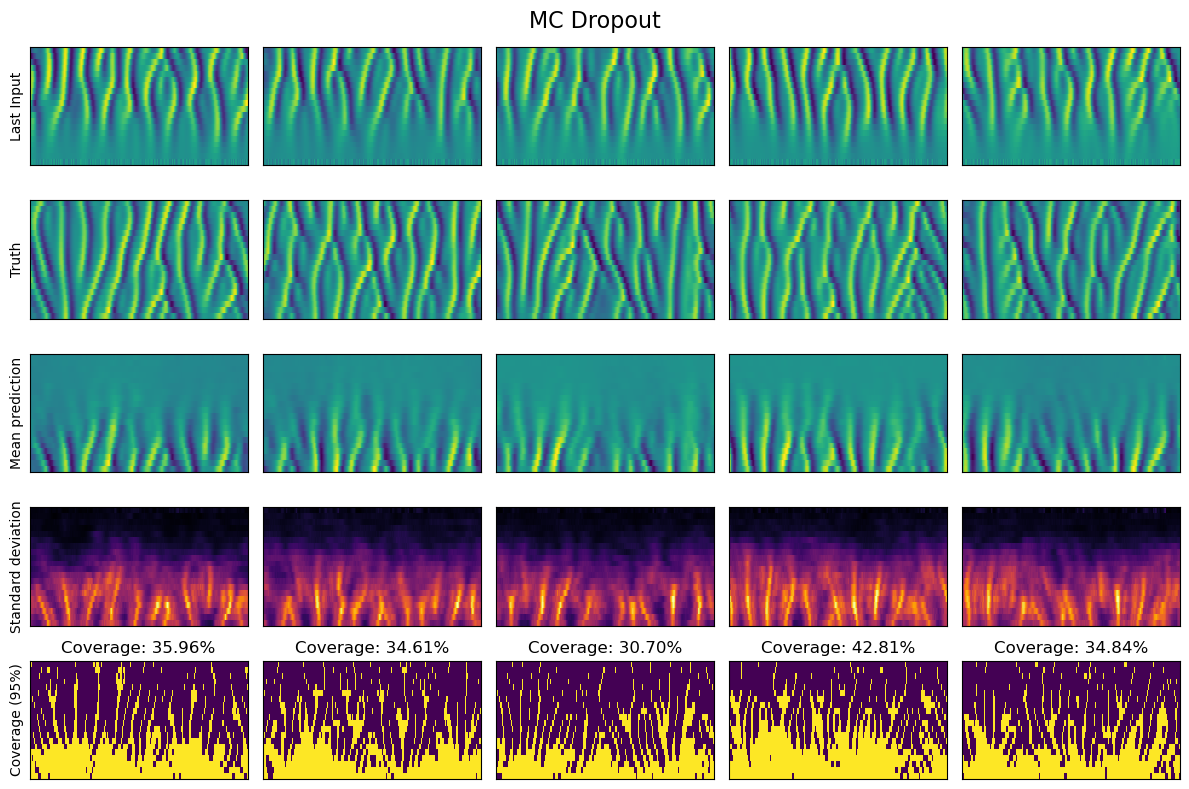

In [18]:
""" Plotting """ 
fig, axs = plt.subplots(5, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(samples):
        a,u = test_data.__getitem__(sample)
        a = a.cpu().numpy()
        u = u.cpu().numpy()
        # Calculate coverage
        q_lower = np.quantile(pred_dropout[i,0],alpha/2, axis = -1)
        q_upper = np.quantile(pred_dropout[i,0],1-alpha/2, axis = -1)
        coverage = (u>q_lower) & (u<q_upper)

        axs[0,i].pcolormesh(a[0])
        axs[1,i].pcolormesh(u[0])
        axs[2,i].pcolormesh(pred_dropout[i,0].mean(axis = -1))
        axs[3,i].pcolormesh(pred_dropout[i,0].std(axis = -1), cmap = "inferno")
        axs[4,i].pcolormesh(coverage[0], vmin = 0, vmax = 1)
        axs[4,i].set_title(f"Coverage: {coverage[0].mean()*100:.2f}%")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Last Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')
axs[4,0].set_ylabel('Coverage (95%)')
fig.suptitle('MC Dropout', fontsize=16)

fig.tight_layout()

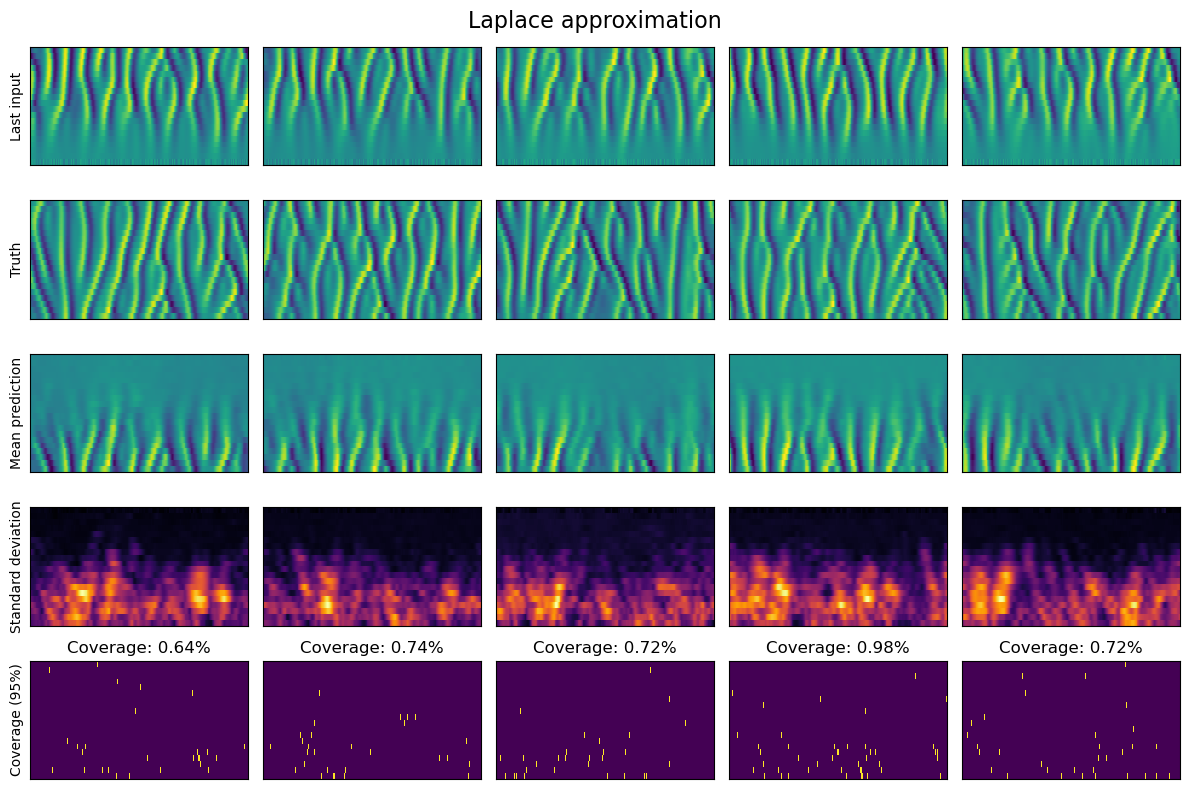

In [19]:
""" Plotting """ 
fig, axs = plt.subplots(5, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(samples):
        a,u = test_data.__getitem__(sample)
        a = a.cpu().numpy()
        u = u.cpu().numpy()
        # Calculate coverage
        q_lower = np.quantile(pred_la[i,0],alpha/2, axis = -1)
        q_upper = np.quantile(pred_la[i,0],1-alpha/2, axis = -1)
        coverage = (u>q_lower) & (u<q_upper)
        axs[0,i].pcolormesh(a[0])
        axs[1,i].pcolormesh(u[0])
        axs[2,i].pcolormesh(pred_la[i,0].mean(axis = -1))
        axs[3,i].pcolormesh(pred_la[i,0].std(axis = -1), cmap = "inferno")
        axs[4,i].pcolormesh(coverage[0], vmin = 0, vmax = 1)
        axs[4,i].set_title(f"Coverage: {coverage[0].mean()*100:.2f}%")


for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Last input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')
axs[4,0].set_ylabel('Coverage (95%)')
fig.suptitle('Laplace approximation', fontsize=16)

fig.tight_layout()

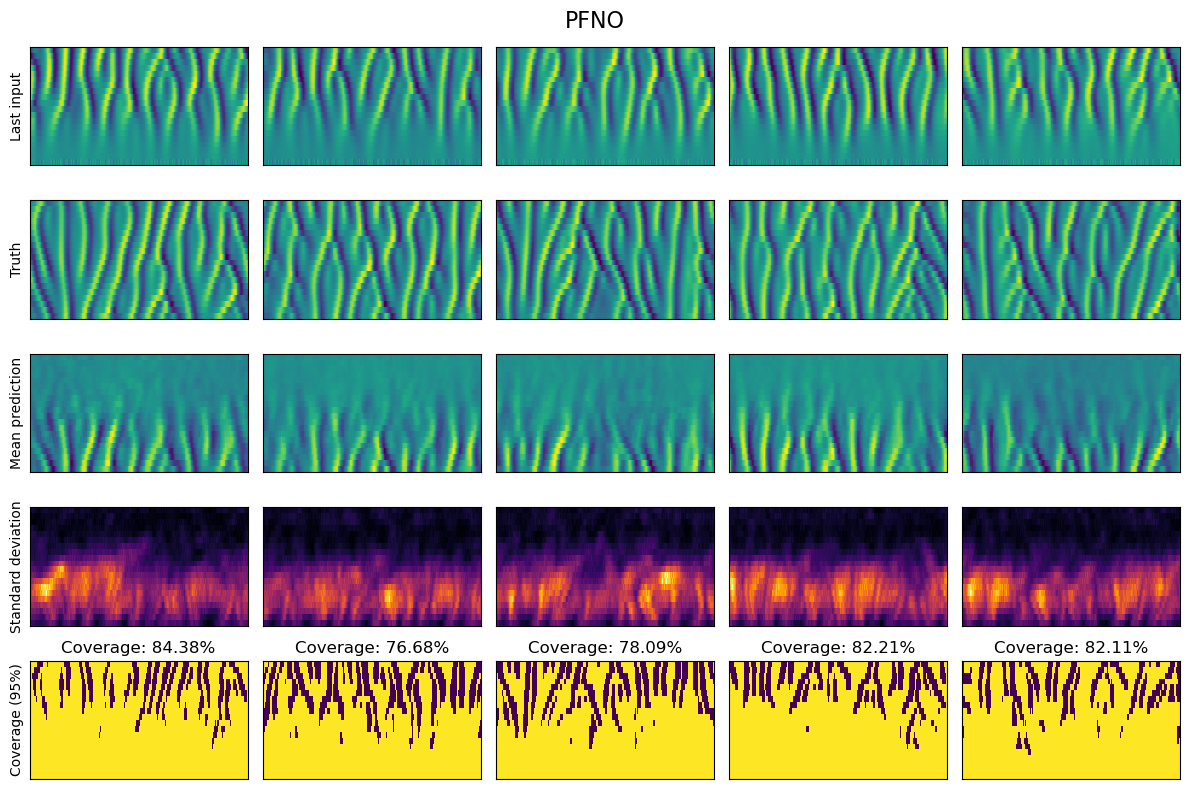

In [20]:
""" Plotting """ 
fig, axs = plt.subplots(5, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(samples):
        a,u = test_data.__getitem__(sample)
        a = a.cpu().numpy()
        u = u.cpu().numpy()
        # Calculate coverage
        q_lower = np.quantile(pred_pfno[i,0],alpha/2, axis = -1)
        q_upper = np.quantile(pred_pfno[i,0],1-alpha/2, axis = -1)
        coverage = (u>q_lower) & (u<q_upper)
        axs[0,i].pcolormesh(a[0])
        axs[1,i].pcolormesh(u[0])
        axs[2,i].pcolormesh(pred_pfno[i,0].mean(axis = -1))
        axs[3,i].pcolormesh(pred_pfno[i,0].std(axis = -1), cmap = "inferno")
        axs[4,i].pcolormesh(coverage[0], vmin = 0, vmax = 1)
        axs[4,i].set_title(f"Coverage: {coverage[0].mean()*100:.2f}%")


for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Last input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')
axs[4,0].set_ylabel('Coverage (95%)')
fig.suptitle('PFNO', fontsize=16)

fig.tight_layout()

# Plot metrics over time

In [21]:
n_samples = 100

In [22]:
samples = np.random.randint(0,n_test,25)

pfno_model.train()
dropout_model.train()
""" Prediction """
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )
        pred_la.append( la_pred )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

Text(0, 0.5, 'Interval width')

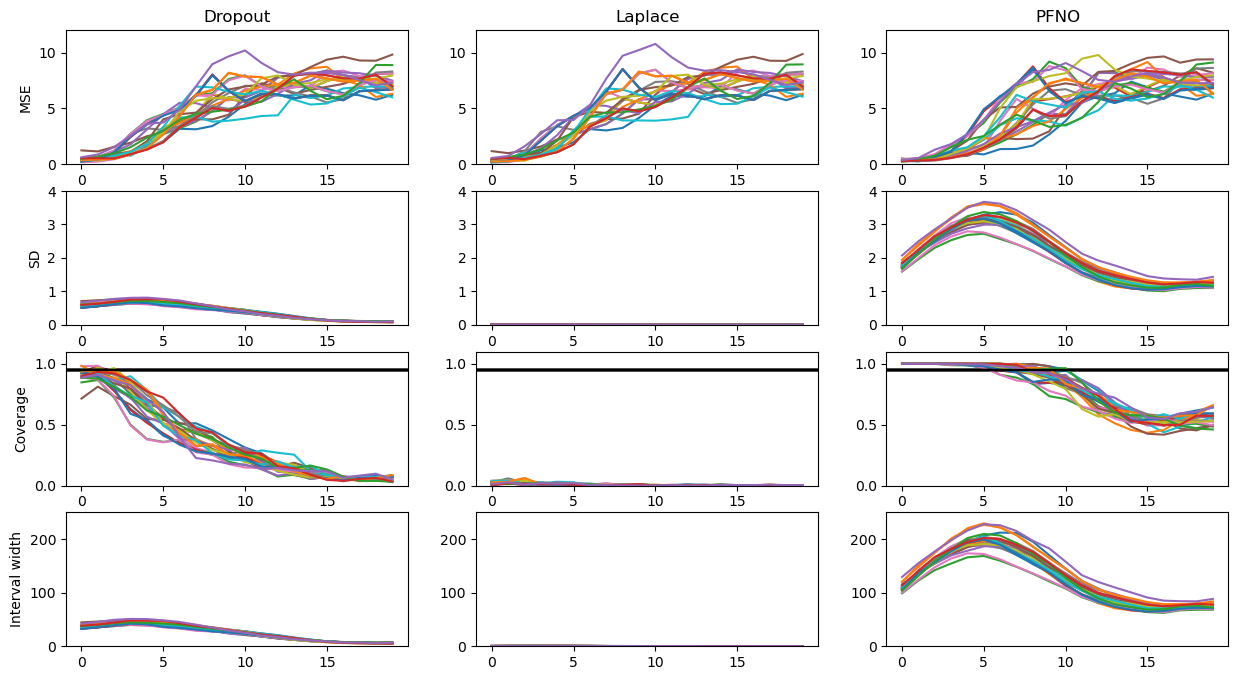

In [24]:
# Plot metrics over time
fig, axs = plt.subplots(4,3, figsize = (15,8))

for i, sample in enumerate(samples):
        a,u = test_data.__getitem__(sample)
        a = a.cpu().numpy()
        u = u.cpu().numpy()
        # Iterate through models
        for m,pred in enumerate([pred_dropout,pred_la,pred_pfno]):
                mse = np.power(pred[i].mean(axis = -1)- u,2).mean(axis = (0,2))
                sd = pred[i].std(axis = -1).mean(axis = (0,2))
                q_lower = np.quantile(pred[i,0],alpha/2, axis = -1)
                q_upper = np.quantile(pred[i,0],1-alpha/2, axis = -1)
                coverage = ((u>q_lower) & (u<q_upper)).mean(axis = (0,2))
                width = np.linalg.norm(q_upper-q_lower, axis = 1)

                axs[0,m].plot(mse)
                axs[0,m].set_ylim([0,12])
                axs[1,m].plot(sd)
                axs[1,m].set_ylim([0,4])
                axs[2,m].plot(coverage)
                axs[2,m].axhline(y=0.95, color='black', linestyle='-')
                axs[2,m].set_ylim([0,1.1])
                axs[3,m].plot(width)
                axs[3,m].set_ylim([0,250])

axs[0,0].set_title("Dropout")
axs[0,1].set_title("Laplace")
axs[0,2].set_title("PFNO")

axs[0,0].set_ylabel("MSE")
axs[1,0].set_ylabel("SD")
axs[2,0].set_ylabel("Coverage")
axs[3,0].set_ylabel("Interval width")
